<a href="https://colab.research.google.com/github/Anna172/ML/blob/master/%D0%90%D0%94%D0%92%D0%91_%D0%94%D0%972_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [40]:
data_train = pd.read_csv("train.csv", delimiter=',',  parse_dates=['period_start_dt'])
data_train.tail()

AttributeError: ignored

In [3]:
print(data_train[data_train['period_start_dt'].dt.year == 2020].shape[0])
print(data_train[ (data_train['period_start_dt'].dt.year == 2019) & (data_train['period_start_dt'].dt.month == 12) ].shape[0])
data_train.shape

0
1200


(35344, 11)

In [4]:
data_test = pd.read_csv("test.csv", delimiter=',',  parse_dates=['period_start_dt'])
data_test

,id,product_rk,store_location_rk,period_start_dt,demand
0,908,40369,317,2019-02-12,NaN
1,909,40370,317,2019-02-12,NaN
2,910,40372,317,2019-02-12,NaN
3,911,40373,317,2019-02-12,NaN
4,912,46272,317,2019-02-12,NaN
...,...,...,...,...,...
1399,35543,40370,1380,2020-06-01,NaN
1400,35544,40372,1380,2020-06-01,NaN
1401,35545,40373,1380,2020-06-01,NaN
1402,35546,46272,1380,2020-06-01,NaN


In [5]:
print(data_test[data_test['period_start_dt'].dt.year == 2020].shape[0])
print(data_test[ (data_test['period_start_dt'].dt.year == 2019) & (data_test['period_start_dt'].dt.month == 12) ].shape[0])
data_test.shape

204
720


(1404, 5)

In [6]:
data_test[ (data_test['period_start_dt'].dt.year == 2019) & (data_test['period_start_dt'].dt.month != 12) ]

,id,product_rk,store_location_rk,period_start_dt,demand
0,908,40369,317,2019-02-12,NaN
1,909,40370,317,2019-02-12,NaN
2,910,40372,317,2019-02-12,NaN
3,911,40373,317,2019-02-12,NaN
4,912,46272,317,2019-02-12,NaN
...,...,...,...,...,...
1375,35519,40370,1380,2019-09-12,NaN
1376,35520,40372,1380,2019-09-12,NaN
1377,35521,40373,1380,2019-09-12,NaN
1378,35522,46272,1380,2019-09-12,NaN


В тренировочном сете нет данных по 2020 году и в задании сказано, что нужно спрогнозировать только на декабрь 2019, поэтому удалим из тестового набора  данных все записи 20 года. 

Согласно заданию, нужно спрогнозировать только декабрь 2019 года, а в тестовом наборе данных 480 наблюдений не декабрь 2019 года, их тоже можно удалить.

В тренировочном наборе данных есть столбец без описания, возможно, это id. Проверим это предположение.

In [7]:
data_test = data_test[ (data_test['period_start_dt'].dt.year == 2019) & (data_test['period_start_dt'].dt.month == 12) ]
data_test.shape

(720, 5)

In [8]:
data_train['id'] = data_train['Unnamed: 0']
m = (data_train[(data_train['period_start_dt'].dt.year == 2019) & (data_train['period_start_dt'].dt.month == 12)].merge(data_test[(data_test['period_start_dt'].dt.year == 2019) & (data_test['period_start_dt'].dt.month == 12)], how='outer', on=['id','product_rk','store_location_rk', 'period_start_dt'], 
              suffixes=['', '_new'], indicator=True))
only2 = m[m['_merge']  == 'left_only']
only2

,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,id,demand_new,_merge
0,908,40369,317,2019-12-02,NaN,0.0,0.0,500.00,500.0,0.0,1.0,908,NaN,left_only
1,909,40370,317,2019-12-02,NaN,0.0,0.0,1000.00,1000.0,0.0,1.0,909,NaN,left_only
2,910,40372,317,2019-12-02,NaN,0.0,0.0,2000.00,2000.0,0.0,1.0,910,NaN,left_only
3,911,40373,317,2019-12-02,NaN,0.0,0.0,3000.00,3000.0,0.0,1.0,911,NaN,left_only
4,912,46272,317,2019-12-02,NaN,1.0,0.0,284.29,199.0,0.0,1.0,912,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,35519,40370,1380,2019-12-09,NaN,0.0,0.0,1000.00,1000.0,0.0,1.0,35519,NaN,left_only
1178,35520,40372,1380,2019-12-09,NaN,0.0,0.0,2000.00,2000.0,0.0,1.0,35520,NaN,left_only
1179,35521,40373,1380,2019-12-09,NaN,0.0,0.0,3000.00,3000.0,0.0,1.0,35521,NaN,left_only
1180,35522,46272,1380,2019-12-09,NaN,1.0,0.0,284.29,199.0,0.0,1.0,35522,NaN,left_only


In [9]:
data_test[(data_test['period_start_dt'].dt.year == 2019) & (data_test['period_start_dt'].dt.month == 12) & (data_test['period_start_dt'].dt.day == 9)]

,id,product_rk,store_location_rk,period_start_dt,demand


In [10]:
data_train[(data_train['period_start_dt'].dt.year == 2019) & (data_train['period_start_dt'].dt.month == 12)]['period_start_dt'].unique()

array(['2019-12-02T00:00:00.000000000', '2019-12-09T00:00:00.000000000',
       '2019-12-16T00:00:00.000000000', '2019-12-23T00:00:00.000000000',
       '2019-12-30T00:00:00.000000000'], dtype='datetime64[ns]')

В предложенном тестовом наборе данных отсутствуют записи за 2 и 9 число декабря. В тренировочном же есть все 5 недель декабря 2019 года и нет ничего лишнего. Соответственно, было решено работать только с тренировочным набором данных и потом уже из него получить тестовый сет. Поэтому переменнуем data_train в data

In [11]:
data = data_train

Предположение подтвердилось, все 720 id по продукту, магазину и дате совпали с предпологаемым id по продукту, магазину и дате в тренировочном сете, поэтому можно переименовать неизвестную колонку в id.

In [12]:
data = data.drop('id', axis=1)
data = data.rename(columns={'Unnamed: 0': 'id'})
print(data.shape)
data.tail()

(35344, 11)


,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
35339,35537,40370,1380,2019-12-30,NaN,0.0,0.0,1000.00,1000.0,0.0,1.0
35340,35538,40372,1380,2019-12-30,NaN,0.0,0.0,2000.00,2000.0,0.0,1.0
35341,35539,40373,1380,2019-12-30,NaN,0.0,0.0,3000.00,3000.0,0.0,1.0
35342,35540,46272,1380,2019-12-30,NaN,1.0,0.0,284.29,199.0,0.0,1.0
35343,35541,96212,1380,2019-12-30,NaN,1.0,0.0,141.43,99.0,0.0,1.0


По каждой переменной набора данных рассчитаем: число уникальных значений (UNIQUE и PERCENT_UNIQUE), число нудевых значений (ZEROS и PERCENT_ZEROS), число пропущенных значений (NANS и PERCENT_NANS) и тип данных (DATA_TYPE). Результаты приведены в таблице ниже:

In [13]:
columns = ["UNIQUE", 'PERCENT_UNIQUE', 'ZEROS', 'PERCENT_ZEROS', 'NANS', 'PERCENT_NANS', 'DATA_TYPE']
dt = pd.DataFrame(index=data.columns, columns=columns)

for col in data.columns:
  dt.loc[col,"UNIQUE"] = len(data[col].unique())
  dt.loc[col,"PERCENT_UNIQUE"] = dt.loc[col,"UNIQUE"]/len(data[col])*100
  dt.loc[col,"NANS"] = np.sum(data[col].isnull())
  dt.loc[col,"PERCENT_NANS"] = dt.loc[col,"NANS"]/len(data[col])*100
  dt.loc[col,"ZEROS"] = (data[col] == 0).sum()
  dt.loc[col,"PERCENT_ZEROS"] = dt.loc[col,"ZEROS"]/len(data[col])*100
  dt["DATA_TYPE"] = data.dtypes   

dt

,UNIQUE,PERCENT_UNIQUE,ZEROS,PERCENT_ZEROS,NANS,PERCENT_NANS,DATA_TYPE
id,35344,100,1,0.00282933,0,0,int64
product_rk,6,0.016976,0,0,0,0,int64
store_location_rk,41,0.116003,0,0,0,0,int64
period_start_dt,159,0.449864,0,0,0,0,datetime64[ns]
demand,1807,5.11261,5454,15.4312,1200,3.3952,float64
PROMO1_FLAG,4,0.0113173,28323,80.1352,185,0.523427,float64
PROMO2_FLAG,2,0.00565867,35159,99.4766,185,0.523427,float64
PRICE_REGULAR,230,0.650747,0,0,1127,3.18866,float64
PRICE_AFTER_DISC,1037,2.93402,0,0,1132,3.20281,float64
NUM_CONSULTANT,2,0.00565867,35159,99.4766,185,0.523427,float64


Признак NUM_CONSULTANT практически на 100 процентов состоит из 0, следовательно, он не несет никакой информации и его можно удалить из набора данных.

In [14]:
data = data.drop('NUM_CONSULTANT', axis=1)
data.shape

(35344, 10)

Далее посмотрим на demand. У нее остаточно много нулей, нужно понять, нормально ли это.

In [15]:
prod_list = data[data['demand'] == 0]['product_rk'].unique()
prod_list

array([46272, 40372, 96212, 40373, 40369, 40370])

In [16]:
for prod in prod_list:
  y= data[data['product_rk'] == prod].groupby('period_start_dt', as_index=False)['demand'].sum()
y

,period_start_dt,demand
0,2016-12-19,1736.000000
1,2016-12-26,3702.000000
2,2017-01-02,2443.529969
3,2017-01-09,590.000000
4,2017-01-16,512.797814
...,...,...
154,2019-12-02,0.000000
155,2019-12-09,0.000000
156,2019-12-16,0.000000
157,2019-12-23,0.000000


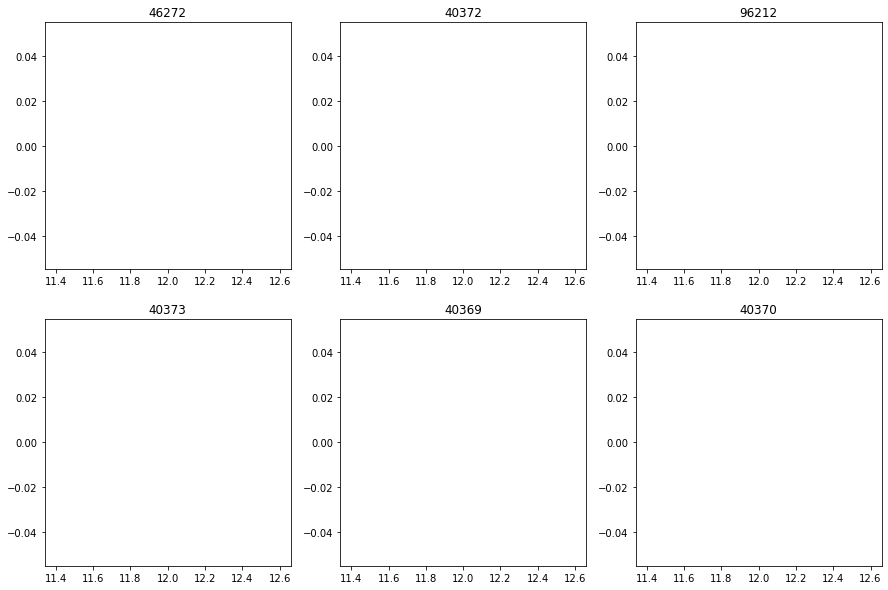

In [35]:
r = 2
c = 3
fig, ax = plt.subplots(r, c, figsize = (c*5, r*5))

i = 0
j = 0

for prod in prod_list:
  y= data[(data['product_rk'] == prod) & (data['period_start_dt'].dt.year == 2019)].groupby('period_start_dt', as_index=False)['demand'].sum()
  y = y[y['demand']<400]
  if (i < r) & (j < c): 
    ax[i, j].plot(y['period_start_dt'].dt.month, y['demand'], color = 'turquoise')
    ax[i, j].set_title(prod)
    j += 1
  elif (i < r) & (j == c):
    j = 0
    i += 1
    ax[i, j].plot(y['period_start_dt'].dt.month, y['demand'], color = 'turquoise')
    ax[i, j].set_title(prod)
    j += 1
  else:
    print('ERROR')  
 
plt.show()

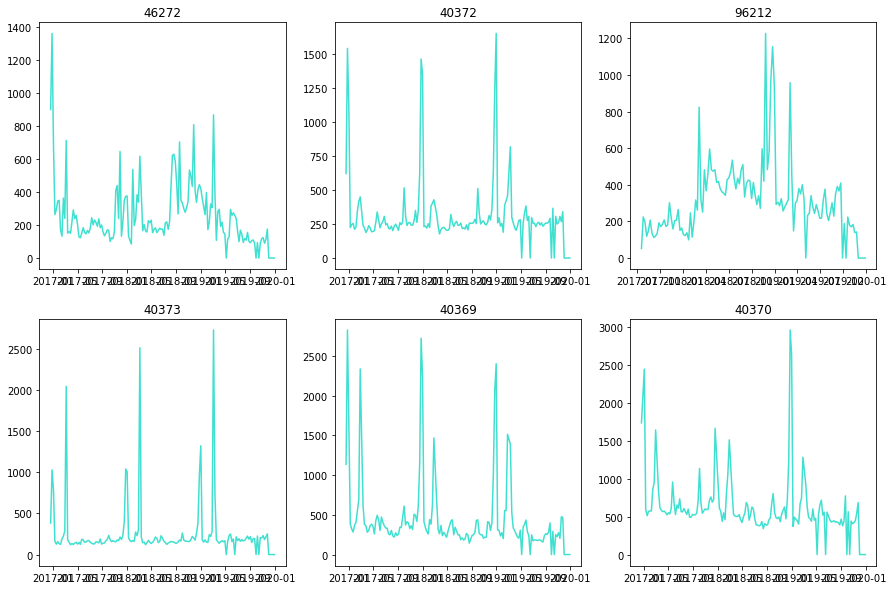

In [18]:
r = 2
c = 3
fig, ax = plt.subplots(r, c, figsize = (c*5, r*5))

i = 0
j = 0

for prod in prod_list:
  y= data[(data['product_rk'] == prod) ].groupby('period_start_dt', as_index=False)['demand'].sum()
  y = y[y['demand']<3000]
  if (i < r) & (j < c): 
    ax[i, j].plot(y['period_start_dt'], y['demand'], color = 'turquoise')
    ax[i, j].set_title(prod)
    j += 1
  elif (i < r) & (j == c):
    j = 0
    i += 1
    ax[i, j].plot(y['period_start_dt'], y['demand'], color = 'turquoise')
    ax[i, j].set_title(prod)
    j += 1
  else:
    print('ERROR')  
 
plt.show()

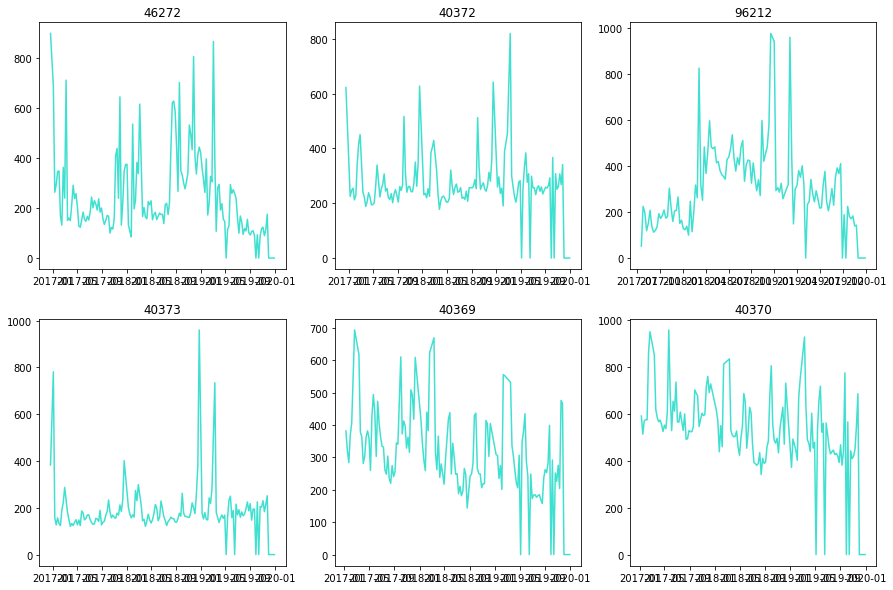

{40369: 307.4636600349653,
 40370: 519.247791140845,
 40372: 263.80649512666645,
 40373: 181.8735214342104,
 46272: 248.10640677848093,
 96212: 298.6593751653543}

In [19]:
r = 2
c = 3
pd = data[data['period_start_dt'].dt.year == 2019]
fig, ax = plt.subplots(r, c, figsize = (c*5, r*5))
means = {}

i = 0
j = 0

for prod in prod_list:
  y= data[(data['product_rk'] == prod) ].groupby('period_start_dt', as_index=False)['demand'].sum()
  y = y[y['demand']<1000]
  if (i < r) & (j < c): 
    means[prod] = y['demand'].mean()
    ax[i, j].plot(y['period_start_dt'], y['demand'], color = 'turquoise')
    ax[i, j].set_title(prod)
    j += 1
  elif (i < r) & (j == c):
    j = 0
    i += 1
    means[prod] = y['demand'].mean()
    ax[i, j].plot(y['period_start_dt'], y['demand'], color = 'turquoise')
    ax[i, j].set_title(prod)
    j += 1
  else:
    print('ERROR')  
 
plt.show()
means

Наблюдаются какие-то совершенно непонятные нули в 2019 году. Скорее всего это ошибки в данных и они будут мешать построению модели, поэтому их нужно заменить. Так как в данных есть выбросы, среднее сильно на них реагирует, поэтому заменим 0 средним значением без учета выбросов.

In [20]:
for key, value in means.items():
  data[data['product_rk'] == key]['demand'] = data[data['product_rk'] == key]['demand'].replace(0, value)

data

,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG
0,307.46366,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN
1,1.00000,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN
2,2.00000,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN
3,3.00000,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN
4,4.00000,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
35339,35537.00000,40370,1380,2019-12-30,NaN,519.247791,519.247791,1000.00,1000.0,1.0
35340,35538.00000,40372,1380,2019-12-30,NaN,263.806495,263.806495,2000.00,2000.0,1.0
35341,35539.00000,40373,1380,2019-12-30,NaN,181.873521,181.873521,3000.00,3000.0,1.0
35342,35540.00000,46272,1380,2019-12-30,NaN,1.000000,248.106407,284.29,199.0,1.0


Посмотрим, как изменилась картина по нулевым значениям спроса:

In [22]:
columns = ["UNIQUE", 'PERCENT_UNIQUE', 'ZEROS', 'PERCENT_ZEROS', 'NANS', 'PERCENT_NANS', 'DATA_TYPE']
#dt = pd.DataFrame(index=data.columns, columns=columns)

for col in data.columns:
  dt.loc[col,"UNIQUE"] = len(data[col].unique())
  dt.loc[col,"PERCENT_UNIQUE"] = dt.loc[col,"UNIQUE"]/len(data[col])*100
  dt.loc[col,"NANS"] = np.sum(data[col].isnull())
  dt.loc[col,"PERCENT_NANS"] = dt.loc[col,"NANS"]/len(data[col])*100
  dt.loc[col,"ZEROS"] = (data[col] == 0).sum()
  dt.loc[col,"PERCENT_ZEROS"] = dt.loc[col,"ZEROS"]/len(data[col])*100
  dt["DATA_TYPE"] = data.dtypes   

dt

,UNIQUE,PERCENT_UNIQUE,ZEROS,PERCENT_ZEROS,NANS,PERCENT_NANS,DATA_TYPE
id,35344,100,0,0,0,0,float64
product_rk,6,0.016976,0,0,0,0,int64
store_location_rk,41,0.116003,0,0,0,0,int64
period_start_dt,159,0.449864,0,0,0,0,datetime64[ns]
demand,1812,5.12675,0,0,1200,3.3952,float64
PROMO1_FLAG,9,0.025464,0,0,185,0.523427,float64
PROMO2_FLAG,7,0.0198053,0,0,185,0.523427,float64
PRICE_REGULAR,230,0.650747,0,0,1127,3.18866,float64
PRICE_AFTER_DISC,1037,2.93402,0,0,1132,3.20281,float64
NUM_CONSULTANT,2,0.00565867,35159,99.4766,185,0.523427,NaN


Все, в перепенной demand не осталось странных нулевых значений, а пропущенные значения в нем, как выяснилось ранее - это как раз то, что нам нужно предсказать.

Далее нужно разобраться с пропущенными значениями переменной PROCE_REGULAR. Их хоть и не много в процентном соотношении, однако они могут быть в декабре, а это значимые наблюдения, если наблюдается цикличность.

In [29]:
data[data['PRICE_REGULAR'].isnull() ]


,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG
0,307.46366,40369,309,2016-12-19,29.000000,NaN,NaN,NaN,NaN,NaN
1,1.00000,40370,309,2016-12-19,64.000000,NaN,NaN,NaN,NaN,NaN
2,2.00000,40372,309,2016-12-19,32.000000,NaN,NaN,NaN,NaN,NaN
3,3.00000,40373,309,2016-12-19,10.000000,NaN,NaN,NaN,NaN,NaN
4,4.00000,46272,309,2016-12-19,15.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
30477,30640.00000,40373,1281,2016-12-19,46.000000,NaN,NaN,NaN,NaN,NaN
30478,30641.00000,46272,1281,2016-12-19,55.000000,NaN,NaN,NaN,NaN,NaN
35019,35217.00000,40369,1380,2018-12-17,307.463660,307.463660,307.463660,NaN,NaN,307.463660
35021,35219.00000,40372,1380,2018-12-17,263.806495,263.806495,263.806495,NaN,NaN,263.806495


Так оно и есть, пропуски выпали на декабрь 16 года. 

In [ ]:
for key, value in means.items():
  data[data['product_rk'] == key] 

data

In [ ]:
data[ (data['PRICE_REGULAR'].isnull()) & (data['period_start_dt'].dt.year == 2017) & (data['period_start_dt'].dt.month == 1)  ].head(20)

In [27]:
data.head()

,id,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG
0,307.46366,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN
1,1.00000,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN
2,2.00000,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN
3,3.00000,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN
4,4.00000,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN
